# Gridsearch

### Import modules

In [147]:
import pandas as pd
import numpy as np

from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix,precision_recall_curve
from sklearn.metrics import roc_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

## Construction pipeline

In [2]:
dataset_merged = DatasetBuilder("data.csv", "socio_eco.csv").create_dataset()
RANDOM_STATE = 42
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=RANDOM_STATE)

X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_train.shape

(36108, 32)

## UnderSampling + OverSampling ( SMOTEENN ) 

In [3]:
smote_enn = SMOTEENN(sampling_strategy=1, random_state=RANDOM_STATE, n_jobs=-1)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [4]:
X_train_resampled.shape

(57640, 32)

## Logistic Regression

In [7]:
lr = LogisticRegression()

#lr.get_params().keys()
#search.best_params_

params_grid_lr = {
                  'penalty' : ['l1', 'l2'],
                  'C' : np.logspace(-3,3,7),
                  'solver' : ['saga', 'lbfgs']}

search = GridSearchCV(lr, params_grid_lr, n_jobs=-1, cv=cv, verbose=0, scoring='recall')

search.fit(X_train_resampled, y_train_resampled)

y_pred = search.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search.best_score_}\n') 
print(f'\nLe meilleur score test est : {search.score(X_test, y_test)}') 


Le meilleur score entraînement est : 0.92673040832995


Le meilleur score test est : 0.9034676663542643


In [8]:
search.best_params_

{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

In [9]:
y_true, y_pred = y_test, search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7961
           1       0.38      0.90      0.53      1067

    accuracy                           0.81      9028
   macro avg       0.68      0.85      0.71      9028
weighted avg       0.91      0.81      0.84      9028



## Support Vector Classification

In [ ]:
svc = SVC()

#svc.get_params().keys()
#search.best_params_


params_grid_svc = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

search = GridSearchCV(svc, params_grid_svc, n_jobs=-1, cv=cv, verbose=1, scoring='recall')

search.fit(X_train_resampled, y_train_resampled)

y_pred = search.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search.best_score_}\n') 
print(f'\nLe meilleur score test est : {search.score(X_test, y_test)}') 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


In [85]:
y_true, y_pred = y_test, search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          No       0.92      0.98      0.95      7636
         Yes       0.65      0.35      0.45      1030

    accuracy                           0.90      8666
   macro avg       0.79      0.66      0.70      8666
weighted avg       0.89      0.90      0.89      8666



## Gaussian Naive Bayes

In [21]:
gnb = GaussianNB()

#gnb.get_params().keys()
#search.best_params_

params_grid_gnb = {'priors' : [None],
                   'var_smoothing' : [0.00000001, 0.000000001, 0.00000001]}

search = GridSearchCV(gnb, params_grid_gnb, n_jobs=-1, cv=cv, verbose=0, scoring='recall')

search.fit(X_train_resampled, y_train_resampled)

y_pred = search.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search.best_score_}\n') # 0.8350
print(f'\nLe meilleur score test est : {search.score(X_test, y_test)}') # 0.8262


Le meilleur score entraînement est : 0.7512323559354585


Le meilleur score test est : 0.722972972972973


In [22]:
y_true, y_pred = y_test, search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      7992
           1       0.33      0.72      0.46      1036

    accuracy                           0.80      9028
   macro avg       0.65      0.77      0.67      9028
weighted avg       0.89      0.80      0.83      9028



## KNeighbors Classifier

In [29]:
from tqdm.notebook import tqdm
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,7)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in tqdm(enumerate(neighbors)):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_resampled, y_train_resampled)
    train_accuracy[i] = knn.score(X_train_resampled, y_train_resampled)
    test_accuracy[i] = knn.score(X_test, y_test) 

TypeError: __init__() got an unexpected keyword argument 'scoring'

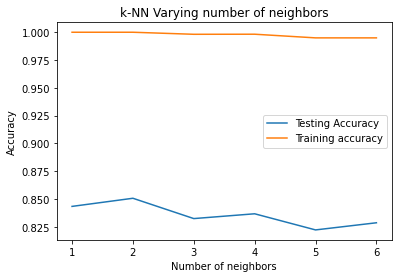

In [28]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [35]:
knc = KNeighborsClassifier()

#knc.get_params().keys()
#search.best_params_

params_grid_knc = {'n_neighbors': [2, 3],
                   'leaf_size': [30],
                   'p': [1]}

search_knn = GridSearchCV(knc, params_grid_knc, n_jobs=-1, cv=cv, verbose=1, scoring='recall')

search_knn.fit(X_train_resampled, y_train_resampled)

y_pred = search_knn.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search_knn.best_score_}\n') 
print(f'\nLe meilleur score test est : {search_knn.score(X_test, y_test)}') 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished



Le meilleur score entraînement est : 0.9987195185315072


Le meilleur score test est : 0.7847490347490348


In [36]:
y_true, y_pred = y_test, search_knn.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      7992
           1       0.41      0.78      0.54      1036

    accuracy                           0.85      9028
   macro avg       0.69      0.82      0.73      9028
weighted avg       0.90      0.85      0.87      9028



## Decision Tree Classifier

In [96]:
dtc =DecisionTreeClassifier()

#dtc.get_params().keys()
#search.best_params_

params_grid_dtc = {'criterion': ["gini", "entropy"],
                   'splitter': ["best"],
                   'max_depth': [4],
                   'min_samples_split': [1,2,3],
                   'min_samples_leaf': [1,3]}

search_dtc = GridSearchCV(dtc, params_grid_dtc, n_jobs=-1, cv=cv, verbose=1, scoring='recall')

search_dtc.fit(X_train_resampled, y_train_resampled)

y_pred = search_dtc.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search_dtc.best_score_}\n') 
print(f'\nLe meilleur score test est : {search_dtc.score(X_test, y_test)}') 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.6s finished



Le meilleur score entraînement est : 0.9384842651382623


Le meilleur score test est : 0.9128397375820057


In [48]:
search_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [97]:
y_true, y_pred = y_test, search_dtc.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      7961
           1       0.35      0.91      0.51      1067

    accuracy                           0.79      9028
   macro avg       0.67      0.84      0.69      9028
weighted avg       0.91      0.79      0.82      9028



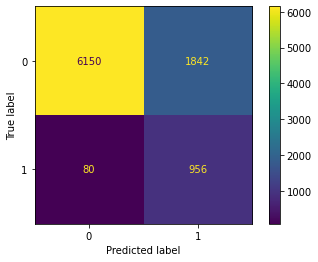

In [54]:
plot_confusion_matrix(search_dtc,X_test, y_test)

## RandomForest Classifier

In [62]:
rf = RandomForestClassifier()

#rf.get_params().keys()
#search.best_params_

params_grid_rf = {'bootstrap': [True, False],
                  'max_features': ['auto'],
                  'n_estimators': [100, 150],
                  'criterion': ["gini", "entropy"],
                  'max_depth': [None],
                  'min_samples_split': [2,3],
                  'min_samples_leaf': [1]}

search_rf = GridSearchCV(rf, params_grid_rf, n_jobs=-1, cv=cv, verbose=0, scoring='recall')

search_rf.fit(X_train_resampled, y_train_resampled)

y_pred = search_rf.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search_rf.best_score_}\n') 
print(f'\nLe meilleur score test est : {search_rf.score(X_test, y_test)}')


Le meilleur score entraînement est : 0.9892439228704297


Le meilleur score test est : 0.861003861003861


In [64]:
search_rf.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [63]:
y_true, y_pred = y_test, search_rf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7992
           1       0.48      0.86      0.62      1036

    accuracy                           0.88      9028
   macro avg       0.73      0.87      0.77      9028
weighted avg       0.92      0.88      0.89      9028



## GradientBoosting Classifier

In [157]:
gbc = GradientBoostingClassifier()

#gbc.get_params().keys()
#search.best_params_

params_grid_gbc = {'n_estimators': [100],
                   'loss': ['deviance'],
                   'learning_rate': [0.001, 0.01, 0.1,0.5,1],
                   'max_depth': [3,4]}

search_gbc = GridSearchCV(gbc, params_grid_gbc, n_jobs=-1, cv=cv, verbose=1)

search_gbc.fit(X_train_resampled, y_train_resampled)

y_pred = search_gbc.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search_gbc.best_score_}\n') 
print(f'\nLe meilleur score test est : {search_gbc.score(X_test, y_test)}') 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished



Le meilleur score entraînement est : 0.9778507984690752


Le meilleur score test est : 0.8808152414709792


In [159]:
search_gbc.best_params_

{'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 100}

In [158]:
y_true, y_pred = y_test, search_gbc.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7961
           1       0.50      0.82      0.62      1067

    accuracy                           0.88      9028
   macro avg       0.74      0.85      0.77      9028
weighted avg       0.92      0.88      0.89      9028



In [160]:
search_gbc.best_params_

{'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 100}

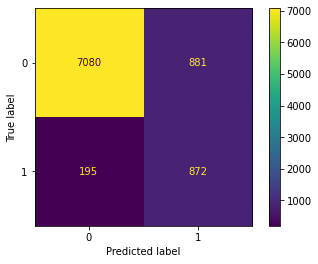

In [161]:
plot_confusion_matrix(search_gbc,X_test, y_test)

## AdaBoost Classifier

In [78]:
abc = AdaBoostClassifier()

#abc.get_params().keys()
#search.best_params_

params_grid_abc = {'n_estimators': [100],
                   'learning_rate': [0.001, 0.01, 0.1 , 0.5 , 1]}

search_abc = GridSearchCV(abc, params_grid_abc, n_jobs=-1, cv=cv, verbose=0, scoring='recall')

search_abc.fit(X_train_resampled, y_train_resampled)

y_pred = search_abc.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search_abc.best_score_}\n') 
print(f'\nLe meilleur score test est : {search_abc.score(X_test, y_test)}') 


Le meilleur score entraînement est : 0.963121801665824


Le meilleur score test est : 0.8223938223938224


In [79]:
y_true, y_pred = y_test, search_abc.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      7992
           1       0.47      0.82      0.60      1036

    accuracy                           0.87      9028
   macro avg       0.72      0.85      0.76      9028
weighted avg       0.92      0.87      0.89      9028



## XGBoost Classifier

In [170]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [160]:
clf = XGBClassifier()

#boost.get_params().keys()
#search.best_params_
weights = [1, 10, 25, 50]
params_grid_xgb =  dict(scale_pos_weight=weights)
param_grid = {
        'scale_pos_weight':[1, 10, 25, 50],
        'min_child_weight': [2,5],
        'gamma': [4,5],
        'subsample': [0.1,1.0],
        'colsample_bytree': [ 0.1, 0.5],
        'max_depth': [2,3]}

search_xgb = GridSearchCV(boost, params_grid_xgb, n_jobs=-1, cv=cv, verbose=1, scoring='recall')

search_xgb.fit(X_train_resampled, y_train_resampled)

y_pred = search_xgb.predict(X_test)

print(f'\nLe meilleur score entraînement est : {search_xgb.best_score_}\n') 
print(f'\nLe meilleur score test est : {search_xgb.score(X_test, y_test)}') 

Best params for recall_score
{'colsample_bytree': 0.1, 'gamma': 4, 'max_depth': 2, 'min_child_weight': 2, 'scale_pos_weight': 50, 'subsample': 1.0}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      4669      3292
pos        12      1055


              precision    recall  f1-score   support

           0       0.99      0.78      0.87      7961
           1       0.36      0.92      0.52      1067

    accuracy                           0.80      9028
   macro avg       0.67      0.85      0.69      9028
weighted avg       0.91      0.80      0.83      9028



## Explication modèle

In [168]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [176]:
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [1,3], 
    'n_estimators' : [50],
    'max_depth': [1,3],
    'max_features': [ 10,15]
}
grid_search_clf = grid_search_wrapper(refit_score='recall_score')




Best params for recall_score
{'max_depth': 3, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 50}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      6213      1748
pos        85       982


In [ ]:
y_true, y_pred = y_test, grid_search_clf.predict(X_test)
print(classification_report(y_true, y_pred))

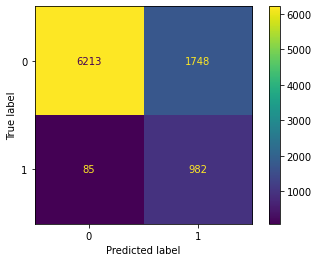

In [187]:
plot_confusion_matrix(grid_search_clf,X_test, y_test)

In [178]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

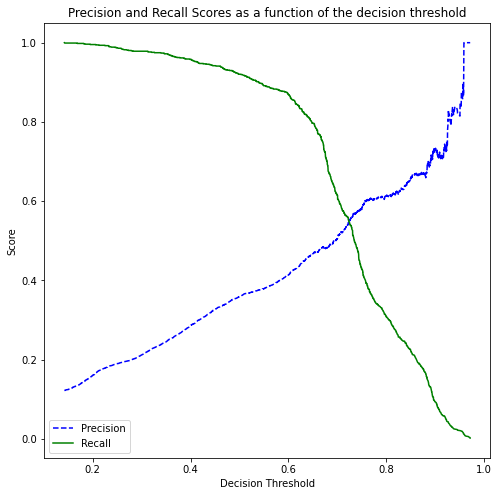

In [179]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [186]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 30,10

In [179]:
from sklearn.model_selection import cross_val_predict
from matplotlib import pyplot


In [181]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [182]:
yhat = grad_clf.predict_proba(X_test)
pos_probs = yhat[:, 1]
pos_probs = y_scores

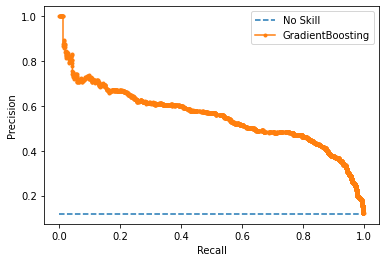

In [184]:
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='GradientBoosting')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt the legend
plt.legend()
# show the plot
plt.show()

In [195]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier()

In [185]:
yhat = grad_clf.predict_proba(X_test)
pos_probs = yhat[:, 1]
pos_probs = y_scores

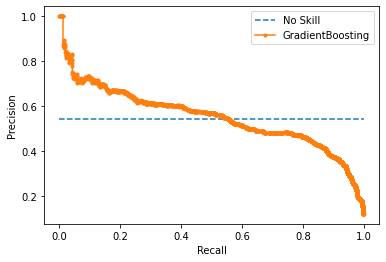

In [186]:
no_skill = len(y_train_resampled[y_train_resampled==1]) / len(y_train_resampled)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='GradientBoosting')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [109]:
yhat = xgb_model.predict_proba(X_test)
pos_probs = yhat[:, 1]

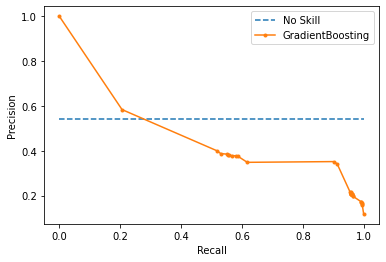

In [111]:
no_skill = len(y_train_resampled[y_train_resampled==1]) / len(y_train_resampled)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='GradientBoosting')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()